Initialization comparison completed!


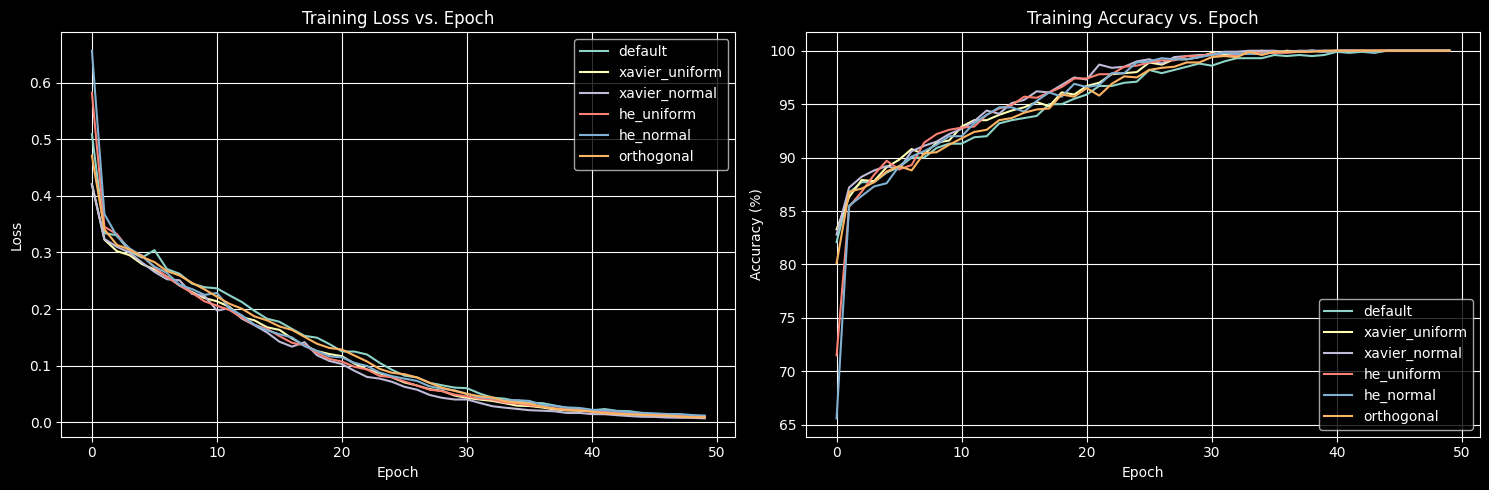

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from torch.utils.data import TensorDataset, DataLoader

class SimpleNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, init_method='default'):
        super(SimpleNet, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        
        # Apply the specified initialization method
        self.initialize_weights(init_method)
    
    def initialize_weights(self, method):
        """
        Initialize network weights using different methods
        
        Args:
            method: Initialization method to use
        """
        for layer in [self.layer1, self.layer2, self.layer3]:
            if method == 'xavier_uniform':
                nn.init.xavier_uniform_(layer.weight)
            elif method == 'xavier_normal':
                nn.init.xavier_normal_(layer.weight)
            elif method == 'he_uniform':
                nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
            elif method == 'he_normal':
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
            elif method == 'orthogonal':
                nn.init.orthogonal_(layer.weight)
            # Default PyTorch initialization if no method specified
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

def generate_dataset(n_samples=1000):
    """
    Generate a synthetic classification dataset
    """
    X, y = make_classification(
        n_samples=n_samples,
        n_features=20,
        n_classes=2,
        n_clusters_per_class=2,
        n_redundant=5,
        random_state=42
    )
    return torch.FloatTensor(X), torch.LongTensor(y)

def train_model(model, train_loader, criterion, optimizer, n_epochs=50):
    """
    Train the model and return training history
    """
    loss_history = []
    accuracy_history = []
    
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
        
        # Calculate epoch metrics
        avg_loss = epoch_loss / len(train_loader)
        accuracy = 100 * correct / total
        
        loss_history.append(avg_loss)
        accuracy_history.append(accuracy)
    
    return loss_history, accuracy_history

def compare_initializations():
    """
    Compare different initialization methods
    """
    # Set random seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    
    # Generate dataset
    X_train, y_train = generate_dataset()
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # Initialize parameters
    input_size = 20
    hidden_size = 100
    output_size = 2
    learning_rate = 0.001
    n_epochs = 50
    
    # Dictionary to store results
    results = {}
    
    # List of initialization methods to compare
    init_methods = [
        'default',
        'xavier_uniform',
        'xavier_normal',
        'he_uniform',
        'he_normal',
        'orthogonal'
    ]
    
    # Train models with different initializations
    for init_method in init_methods:
        model = SimpleNet(input_size, hidden_size, output_size, init_method)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        loss_history, acc_history = train_model(
            model, train_loader, criterion, optimizer, n_epochs
        )
        
        results[init_method] = {
            'loss': loss_history,
            'accuracy': acc_history
        }
    
    # Plotting results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training loss
    for method in init_methods:
        ax1.plot(results[method]['loss'], label=method)
    ax1.set_title('Training Loss vs. Epoch')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot training accuracy
    for method in init_methods:
        ax2.plot(results[method]['accuracy'], label=method)
    ax2.set_title('Training Accuracy vs. Epoch')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    return plt

if __name__ == "__main__":
    plt = compare_initializations()
    print("Initialization comparison completed!")

In [3]:
import numpy as np
import torch
import torch.nn as nn

class LSUVInitializer:
    def __init__(self, target_variance=1.0, max_attempts=20, tolerance=0.1):
        """
        Initialize LSUV with parameters
        
        Args:
            target_variance: Desired variance for layer outputs (default=1.0)
            max_attempts: Maximum iterations for variance adjustment
            tolerance: Acceptable deviation from target variance
        """
        self.target_variance = target_variance
        self.max_attempts = max_attempts
        self.tolerance = tolerance

    def orthonormal_initialization(self, tensor):
        """
        Initialize a tensor with orthonormal values using QR decomposition
        
        Args:
            tensor: Weight tensor to initialize
        """
        shape = tensor.shape
        if len(shape) < 2:
            return tensor
        
        # Flatten weights to 2D
        flattened = tensor.reshape(shape[0], -1)
        
        # Generate random matrix
        random_matrix = torch.randn(flattened.shape)
        
        # Perform QR decomposition
        q, r = torch.qr(random_matrix)
        
        # Ensure deterministic behavior by adjusting signs
        d = torch.diag(r, 0)
        ph = d.sign()
        q *= ph
        
        # Reshape back to original tensor shape
        return q.reshape(shape)

    def compute_layer_variance(self, layer, input_data):
        """
        Compute variance of layer outputs for given input data
        
        Args:
            layer: Neural network layer
            input_data: Batch of input data
        Returns:
            Variance of layer outputs
        """
        # Forward pass through the layer
        with torch.no_grad():
            output = layer(input_data)
        
        # Compute variance across all dimensions except batch
        variance = output.var(dim=0).mean()
        return variance.item()

    def adjust_variance(self, layer, input_data):
        """
        Iteratively adjust layer weights to achieve target variance
        
        Args:
            layer: Neural network layer
            input_data: Batch of input data
        Returns:
            bool: Whether adjustment was successful
        """
        for attempt in range(self.max_attempts):
            current_variance = self.compute_layer_variance(layer, input_data)
            
            # Check if variance is within tolerance
            if abs(current_variance - self.target_variance) < self.tolerance:
                return True
            
            # Compute scaling factor
            scaling_factor = np.sqrt(self.target_variance / (current_variance + 1e-8))
            
            # Adjust weights
            with torch.no_grad():
                if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
                    layer.weight.data *= scaling_factor
        
        return False

    def initialize_layer(self, layer, input_data):
        # Example initialization process for a single layer
        with torch.no_grad():
            layer.weight.data.normal_(0, 1)
            layer.bias.data.zero_()
            output_data = layer(input_data)
            mean = output_data.mean().item()
            std = output_data.std().item()
            layer.weight.data /= std
            layer.bias.data -= mean

    def initialize_model(self, model, input_data):
        # Ensure input_data has the correct shape
        if input_data.shape[1] != 784:
            raise ValueError(f"Expected input data with shape (batch_size, 784), but got {input_data.shape}")
        
        # Example LSUV initialization process
        for layer in model:
            if isinstance(layer, nn.Linear):
                self.initialize_layer(layer, input_data)
                input_data = layer(input_data)  # Forward pass to get the next input data

# Example usage
def example_usage():
    # Create a simple model
    model = nn.Sequential(
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    )
    
    # Create sample input data
    batch_size = 32
    input_data = torch.randn(batch_size, 784)
    
    # Initialize LSUV
    initializer = LSUVInitializer()
    
    # Apply LSUV initialization
    initializer.initialize_model(model, input_data)
    
    return model

if __name__ == "__main__":
    model = example_usage()
    print("Model initialized using LSUV")

Model initialized using LSUV


<module 'matplotlib.pyplot' from '/home/alibina/miniconda3/envs/fastai/lib/python3.11/site-packages/matplotlib/pyplot.py'>

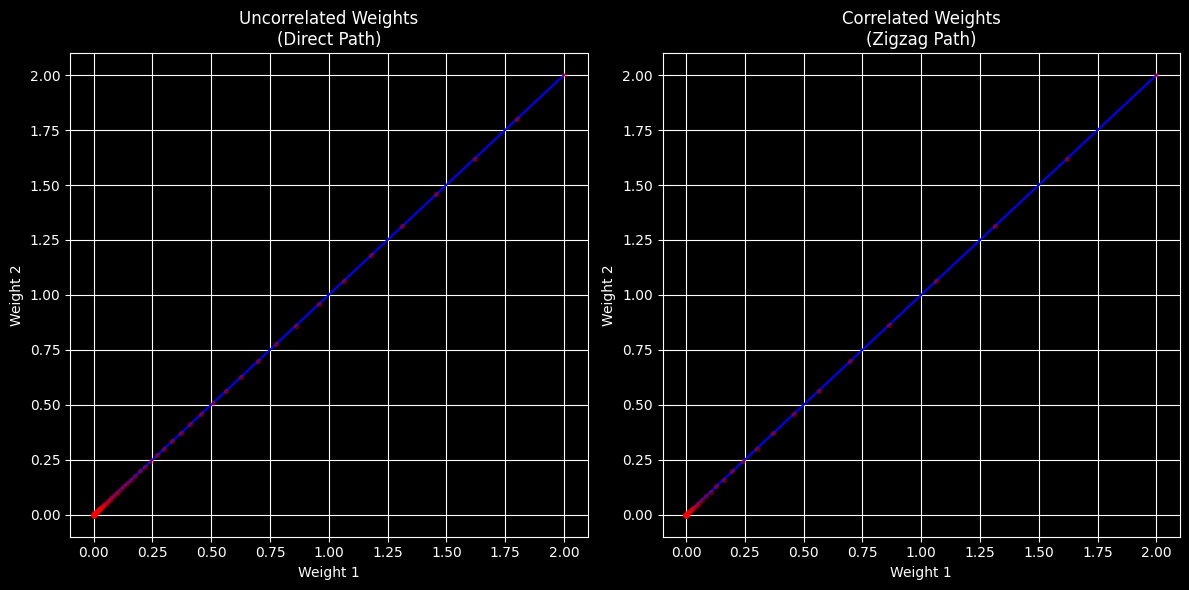

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_optimization_path(correlation, learning_rate, steps=100):
    """
    Simulate optimization path with different weight correlations
    
    Args:
        correlation: Correlation coefficient between weights
        learning_rate: Learning rate for gradient descent
        steps: Number of optimization steps
    """
    # Create correlated weight space
    cov_matrix = np.array([[1, correlation],
                          [correlation, 1]])
    
    # Initialize starting point
    current_point = np.array([2.0, 2.0])
    path = [current_point.copy()]
    
    # Optimal point is at origin
    for _ in range(steps):
        # Compute gradient with correlation effect
        gradient = np.dot(cov_matrix, current_point)
        
        # Update weights
        current_point = current_point - learning_rate * gradient
        path.append(current_point.copy())
    
    return np.array(path)

# Compare optimization paths
def plot_optimization_comparison():
    # Generate paths for different correlations
    uncorrelated_path = simulate_optimization_path(correlation=0.0, learning_rate=0.1)
    correlated_path = simulate_optimization_path(correlation=0.9, learning_rate=0.1)
    
    plt.figure(figsize=(12, 6))
    
    # Plot uncorrelated case
    plt.subplot(1, 2, 1)
    plt.plot(uncorrelated_path[:, 0], uncorrelated_path[:, 1], 'b-', label='Optimization path')
    plt.plot(uncorrelated_path[:, 0], uncorrelated_path[:, 1], 'r.', alpha=0.3)
    plt.title('Uncorrelated Weights\n(Direct Path)')
    plt.xlabel('Weight 1')
    plt.ylabel('Weight 2')
    plt.grid(True)
    
    # Plot correlated case
    plt.subplot(1, 2, 2)
    plt.plot(correlated_path[:, 0], correlated_path[:, 1], 'b-', label='Optimization path')
    plt.plot(correlated_path[:, 0], correlated_path[:, 1], 'r.', alpha=0.3)
    plt.title('Correlated Weights\n(Zigzag Path)')
    plt.xlabel('Weight 1')
    plt.ylabel('Weight 2')
    plt.grid(True)
    
    plt.tight_layout()
    return plt

# Create and save visualization
plot_optimization_comparison()

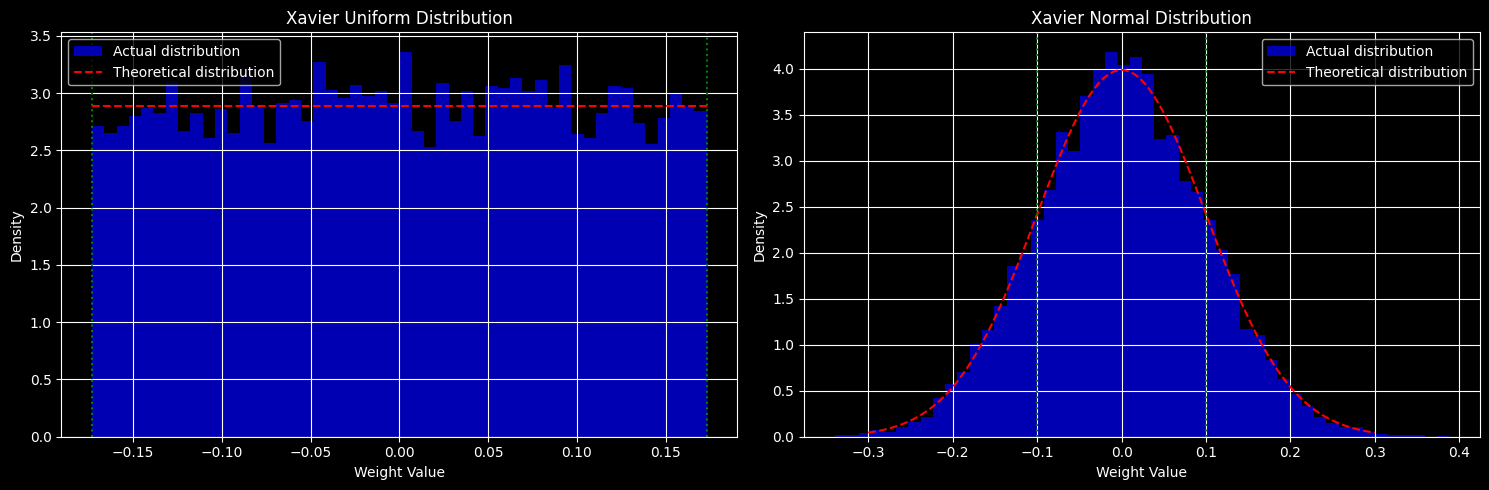

Uniform Statistics:
Theoretical Range: [-0.1732, 0.1732]
Actual Mean: 0.0009
Actual Variance: 0.0098

Normal Statistics:
Theoretical Std Dev: 0.1000
Actual Mean: -0.0003
Actual Variance: 0.0098


In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

def compare_xavier_distributions(input_size=100, output_size=100, n_samples=10000):
    """
    Compare and visualize Xavier Uniform and Normal initializations
    
    Args:
        input_size: Number of input features
        output_size: Number of output features
        n_samples: Number of weight samples to generate
    """

    # Create weight matrices with dimensions [output_size, input_size]
    w_uniform = torch.empty(output_size, input_size)
    w_normal = torch.empty(output_size, input_size)

    # Initialize using Xavier methods
    nn.init.xavier_uniform_(w_uniform)
    nn.init.xavier_normal_(w_normal)

    # Flatten the weight matrices for sampling
    w_uniform_flat = w_uniform.view(-1)[:n_samples]
    w_normal_flat = w_normal.view(-1)[:n_samples]

    # Calculate theoretical bounds and parameters
    fan_in = input_size
    fan_out = output_size

    # Uniform bounds
    uniform_bound = np.sqrt(6.0 / (fan_in + fan_out))

    # Normal standard deviation
    normal_std = np.sqrt(2.0 / (fan_in + fan_out))

    # Create plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot Uniform distribution
    ax1.hist(w_uniform_flat.numpy(), bins=50, density=True, alpha=0.7, color='blue',
             label='Actual distribution')

    # Add theoretical uniform distribution
    x_uniform = np.linspace(-uniform_bound, uniform_bound, 100)
    y_uniform = np.ones_like(x_uniform) / (2 * uniform_bound)
    ax1.plot(x_uniform, y_uniform, 'r--', label='Theoretical distribution')

    ax1.set_title('Xavier Uniform Distribution')
    ax1.set_xlabel('Weight Value')
    ax1.set_ylabel('Density')
    ax1.legend()
    ax1.grid(True)

    # Add theoretical bounds
    ax1.axvline(x=-uniform_bound, color='g', linestyle=':', label='Bounds')
    ax1.axvline(x=uniform_bound, color='g', linestyle=':')

    # Plot Normal distribution
    ax2.hist(w_normal_flat.numpy(), bins=50, density=True, alpha=0.7, color='blue',
             label='Actual distribution')

    # Add theoretical normal distribution
    x_normal = np.linspace(-3*normal_std, 3*normal_std, 100)
    y_normal = stats.norm.pdf(x_normal, 0, normal_std)
    ax2.plot(x_normal, y_normal, 'r--', label='Theoretical distribution')

    ax2.set_title('Xavier Normal Distribution')
    ax2.set_xlabel('Weight Value')
    ax2.set_ylabel('Density')
    ax2.legend()
    ax2.grid(True)

    # Add standard deviation lines
    ax2.axvline(x=-normal_std, color='g', linestyle=':', label='±1 std dev')
    ax2.axvline(x=normal_std, color='g', linestyle=':')

    plt.tight_layout()
    plt.show()  # Display the plots

    # Calculate and print statistics
    print(f"Uniform Statistics:")
    print(f"Theoretical Range: [{-uniform_bound:.4f}, {uniform_bound:.4f}]")
    print(f"Actual Mean: {w_uniform_flat.mean():.4f}")
    print(f"Actual Variance: {w_uniform_flat.var():.4f}")
    print(f"\nNormal Statistics:")
    print(f"Theoretical Std Dev: {normal_std:.4f}")
    print(f"Actual Mean: {w_normal_flat.mean():.4f}")
    print(f"Actual Variance: {w_normal_flat.var():.4f}")

# Generate comparison
plt = compare_xavier_distributions()

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

class GradInit:
    def __init__(self, model, criterion, max_grad_norm=0.1, n_iterations=100):
        """
        Initialize GradInit optimizer
        
        Args:
            model: Neural network model
            criterion: Loss function
            max_grad_norm: Maximum allowed gradient norm
            n_iterations: Number of optimization iterations
        """
        self.model = model
        self.criterion = criterion
        self.max_grad_norm = max_grad_norm
        self.n_iterations = n_iterations
        
        # Create scaling factors for each weight matrix
        self.scaling_factors = []
        for module in model.modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                scale = nn.Parameter(torch.ones(1))
                self.scaling_factors.append(scale)
    
    def apply_scaling(self):
        """Apply current scaling factors to model weights"""
        idx = 0
        for module in self.model.modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                module.weight.data *= self.scaling_factors[idx]
                idx += 1
    
    def compute_grad_norm(self, loss):
        """Compute gradient norm for current parameter settings"""
        gradients = torch.autograd.grad(loss, self.scaling_factors, 
                                      create_graph=True)
        grad_norm = torch.sqrt(sum(g.pow(2).sum() for g in gradients))
        return grad_norm
    
    def optimize(self, inputs, targets):
        """
        Run GradInit optimization
        
        Args:
            inputs: Input data batch
            targets: Target labels/values
        """
        # Freeze original model parameters
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Create optimizer for scaling factors
        optimizer = optim.Adam(self.scaling_factors, lr=0.01)
        
        for iteration in range(self.n_iterations):
            optimizer.zero_grad()
            
            # Forward pass with current scales
            self.apply_scaling()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)
            
            # Compute gradient norm
            grad_norm = self.compute_grad_norm(loss)
            
            # Define optimization objective
            objective = loss
            if grad_norm > self.max_grad_norm:
                # Add penalty for exceeding gradient norm constraint
                objective += 0.1 * (grad_norm - self.max_grad_norm)**2
            
            # Backward pass and update
            objective.backward()
            optimizer.step()
            
            if iteration % 10 == 0:
                print(f"Iteration {iteration}: Loss = {loss.item():.4f}, "
                      f"Grad Norm = {grad_norm.item():.4f}")
        
        # Final application of scaling
        self.apply_scaling()
        
        # Unfreeze model parameters
        for param in self.model.parameters():
            param.requires_grad = True

# Example usage
def example_usage():
    # Create a simple model
    model = nn.Sequential(
        nn.Linear(10, 100),
        nn.ReLU(),
        nn.Linear(100, 1)
    )
    
    # Initialize GradInit
    criterion = nn.MSELoss()
    grad_init = GradInit(model, criterion)
    
    # Generate sample data
    inputs = torch.randn(32, 10)
    targets = torch.randn(32, 1)
    
    # Run GradInit optimization
    grad_init.optimize(inputs, targets)
    
    return model

In [9]:
import torch
import torch.nn as nn
import numpy as np

class FixUpInitialization:
    """
    Implements FixUp initialization for residual networks.
    This class provides methods to initialize weights according to the FixUp paper.
    """
    @staticmethod
    def calculate_scale_factor(num_layers, num_branches):
        """
        Calculate the FixUp scaling factor based on network depth.
        
        Args:
            num_layers (int): Number of layers in each residual branch
            num_branches (int): Total number of residual branches
        """
        return (num_branches ** (-1.0 / (2 * num_layers)))

    @staticmethod
    def init_weights(module, scale_factor=1.0, zero_init=False):
        """
        Initialize weights using FixUp method.
        
        Args:
            module: PyTorch module to initialize
            scale_factor (float): Scaling factor for initialization
            zero_init (bool): Whether to initialize near zero
        """
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            if zero_init:
                nn.init.normal_(module.weight, mean=0, std=1e-4)
            else:
                nn.init.normal_(module.weight, mean=0, 
                              std=np.sqrt(2.0 / module.weight.shape[1]) * scale_factor)
            if module.bias is not None:
                nn.init.zeros_(module.bias)

class FixUpResidualBlock(nn.Module):
    """
    Implements a residual block with FixUp initialization.
    """
    def __init__(self, in_channels, out_channels, stride=1, num_layers=4):
        super().__init__()
        
        # Learnable scalar multiplier (initialized to 1)
        self.scalar = nn.Parameter(torch.ones(1))
        
        # Main branch
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                              stride=stride, padding=1, bias=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                              stride=1, padding=1, bias=True)
        
        # Bias terms for pre-activation
        self.bias1a = nn.Parameter(torch.zeros(1))
        self.bias1b = nn.Parameter(torch.zeros(1))
        self.bias2a = nn.Parameter(torch.zeros(1))
        self.bias2b = nn.Parameter(torch.zeros(1))
        
        # Shortcut connection if dimensions change
        self.shortcut = None
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels,
                                    kernel_size=1, stride=stride, bias=True)
    
    def forward(self, x):
        identity = x
        
        # Main branch with bias terms
        out = x + self.bias1a
        out = self.conv1(out)
        out = out + self.bias1b
        out = self.relu1(out)
        
        out = out + self.bias2a
        out = self.conv2(out)
        out = out + self.bias2b
        
        # Apply scalar multiplier
        out = out * self.scalar
        
        # Shortcut connection
        if self.shortcut is not None:
            identity = self.shortcut(x)
        
        # Add identity
        out += identity
        return out

class FixUpResNet(nn.Module):
    """
    Implements a ResNet variant using FixUp initialization.
    """
    def __init__(self, num_blocks, num_classes=10):
        super().__init__()
        
        self.in_channels = 64
        self.num_branches = sum(num_blocks)
        
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=True)
        
        # Residual layers
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2)
        
        # Final classification layer
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
        # Initialize using FixUp
        self._initialize_weights()
    
    def _make_layer(self, out_channels, num_blocks, stride):
        layers = []
        layers.append(FixUpResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(FixUpResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        # Calculate FixUp scale factor
        scale = FixUpInitialization.calculate_scale_factor(2, self.num_branches)
        
        # Initialize all layers
        for m in self.modules():
            if isinstance(m, FixUpResidualBlock):
                # Initialize main branch
                FixUpInitialization.init_weights(m.conv1, scale)
                # Initialize last conv layer near zero
                FixUpInitialization.init_weights(m.conv2, zero_init=True)
                # Initialize shortcut
                if m.shortcut is not None:
                    FixUpInitialization.init_weights(m.shortcut)
        
        # Initialize first and last layer
        FixUpInitialization.init_weights(self.conv1)
        FixUpInitialization.init_weights(self.fc)
    
    def forward(self, x):
        x = self.conv1(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

# Example usage
def create_model():
    """
    Creates a FixUp ResNet-18 model.
    """
    return FixUpResNet([2, 2, 2, 2])  # Similar to ResNet-18 architecture

# Training example
def train_step(model, optimizer, criterion, data, target):
    """
    Demonstrates a single training step with FixUp ResNet.
    
    Args:
        model: FixUp ResNet model
        optimizer: PyTorch optimizer
        criterion: Loss function
        data: Input batch
        target: Target labels
    """
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    return loss.item()

# Example setup and training
if __name__ == "__main__":
    # Create model
    model = create_model()
    
    # Setup training
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1,
                               momentum=0.9, weight_decay=5e-4)
    criterion = nn.CrossEntropyLoss()
    
    # Generate dummy data for demonstration
    dummy_input = torch.randn(2, 3, 32, 32)
    dummy_target = torch.tensor([1, 0])
    
    # training
    for _ in range(5):
        loss = train_step(model, optimizer, criterion, dummy_input, dummy_target)
        print(f"Training loss: {loss:.4f}")
    
    

Training loss: 7.8817
Training loss: 157372343369334784.0000
Training loss: nan
Training loss: nan
Training loss: nan
